# Simulación y reconstrucción de lente extensa
En este *notebook* se llevará a cabo la simulación de una imagen de una galaxia *lensada* para posteriormente, mediante un algoritmo de reconstrucción, recuperar los parámetros de la lente empleada. 

El algoritmo está inspirado del libro Meneghetti, M. [*Introduction to Gravitational Lensing: With Python Examples*](https://doi.org/10.1007/978-3-030-73582-1). También se hace uso de la librería `lenstronomy` ([Birrer, S. et al.](https://doi.org/10.21105/joss.03283)).

Importamos las funciones necesarias

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Util import util
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.Data.psf import PSF
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## 1. Simulación de la galaxia lensada
En este apartado se simulará la galaxia co
### 1.1 Definimos parámetros de la foto
En `lenstronomy` hay una forma para simular de manera más o menos realista una foto; mediante la clase `PSF` se simulan efectos de dispersión de punto; también se puede simular ruido gaussiano de fondo y ruido de poisson.

In [14]:
# Parámetros de la foto
background_rms = 0.5 # ruido de fondo por píxel
exp_time = 100 # tiempo de exposición
numPix = 200 # numero de píxeles de la imagen
deltaPix = 0.05 # tamaño de pixel en arcosegundos

# Especificamos efecto de dispersión de punto
fwhm = 0.1 
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix,
exp_time,
background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {"psf_type": "GAUSSIAN",
"fwhm": fwhm,
"pixel_size": deltaPix,
"truncation": 5}
psf_class = PSF(**kwargs_psf)

### 1.2 Definimos la lente
Usamos una lente de tipo *Sérsic* elíptica, definida en [Cardone, V. F.](https://doi.org/10.1051/0004-6361:20031696). La convergencia se expresa

$$\kappa(R)=\kappa_{eff}exp[-b_n(R/R_{Sersic})^{\frac{1}{n}}],$$

donde, $b_n\approx 1.999n-0.327$. Se simula una lente de masa $M=10^{12}M_\odot$, fijando primeramente los parámetros $R_{Sersic},n,e_1,e_2$ y mediante la función definda `sersic_m_star2k_eff` conseguimos el parámetro $\kappa_{eff}$. Los parámetros escogidos son:

$$ \{\kappa_{eff}=3.57,R_{Sersic}=0.5'',n=4,e_1=0.1,e_2=0.1\}$$

In [15]:
#Parámetros del sistema
zl=0.3 # redshift de la lente
zs=1.5 # redshift de la fuente
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05) #definimos el modelo cosmológico
lens_cosmo = LensCosmo(z_lens=zl, z_source=zs, cosmo=cosmo)

#Parámetros de la lente
R_sersic = 0.5 
n_sersic = 4
m_star=10**(12) #Masa en masas solares
k_eff = lens_cosmo.sersic_m_star2k_eff(m_star=m_star, R_sersic=R_sersic, 
                                       n_sersic=n_sersic) 

#Definimos la lente Sérsic elípitica
lens_model_list = ["SERSIC_ELLIPSE_POTENTIAL"]
lens_model_class = LensModel(lens_model_list=lens_model_list)
kwargs_sersiclens = {"k_eff": k_eff,'R_sersic':R_sersic,'n_sersic':n_sersic,
"center_x": 0,
"center_y":0,'e1':0.1,'e2':0.1}
kwargs_lens = [kwargs_sersiclens]

### 1.3 Perfiles de luminosidad de la lente y de la fuente
Mediante la clase `LightModel` de lenstronomy se simulará un perfil de luminosidad de tipo *Sèrsic* (típico para simular galaxias):

$$I(R)=I_0exp(-b_n(R/R_{Sersic})^{\frac{1}{n}})$$

Para la lente se escogen los siguientes parámetros

$$ \{amp=400,R_{Sersic}=2'',n=4,e_1=0.1,e_2=0.1,x=0'',y=0''\} $$

Para la fuente se escogen:

$$\{amp=400,R_{Sersic}=2.5'',n=3,e_1=0.1,e_2=0.1,x=0.7'',y=0''\}$$

Obsérvese que la fuente lente están desalineadas pues se ha colocado la lente en la posición $(0'',0'')$ y la fuente en (0.7'',0).

In [16]:
# Perfil de luminosidad para la lente
lens_light_model_list = ["SERSIC_ELLIPSE"]
kwargs_sersic = {"amp":400, # Flujo de la lente (unidades arbitrarias)
"R_sersic": 2 ,# radio efectivo
"n_sersic": 4, # índice sersic
"center_x": 0., # coordenada-x
"center_y": 0., # coordenada-y
"e1": 0.1,
"e2": 0.1}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


# Perfil de luminosidad para la fuente
source_model_list = ["SERSIC_ELLIPSE"]
ra_source, dec_source = 0.7,0 #Posicion de la fuente
kwargs_sersic_ellipse = {"amp": 400.,
"R_sersic": 2.5,
"n_sersic": 3,
"center_x": ra_source,
"center_y": dec_source,
"e1": 0.1,
"e2": 0.3}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

### 1.4 Resolvemos la ecuación de la lente
Al centrar la galaxia fuente en la posición $(0.7'',0)$ el cuásar (que se situa en el centro de la galaxia) estará en esa posición; para conseguir las imágenes del cuásar resolvemos la ecuación de la lente para ese punto.

In [17]:
# Resolvemos la ecuación de la lente para determinar
# posiciones del cuásar. Usamos LensEquationSolver de lenstronomy.
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.image_position_from_source(ra_source,dec_source,
kwargs_lens, min_distance=deltaPix,
search_window=numPix * deltaPix,
precision_limit=1e-10, num_iter_max=100,
arrival_time_sort=True,
initial_guess_cut=True,
verbose=False,
x_center=0,
y_center=0,
num_random=0,
non_linear=False,
magnification_limit=None)

### 1.5 Simulamos la imagen sin lensar
Para simular la imagen sin lensar primero usamos la clase `Point_Source` para simular el cuásar. Los parámetros escogidos son


$$ \{amp=100000,x=0.7'',y=0\} $$

Para crear la imagen se usa la clase `ImageModel`, mediante `add_poisson` añadimos ruido de poisson y mediante `add_background` añadimos ruido de fondo. 

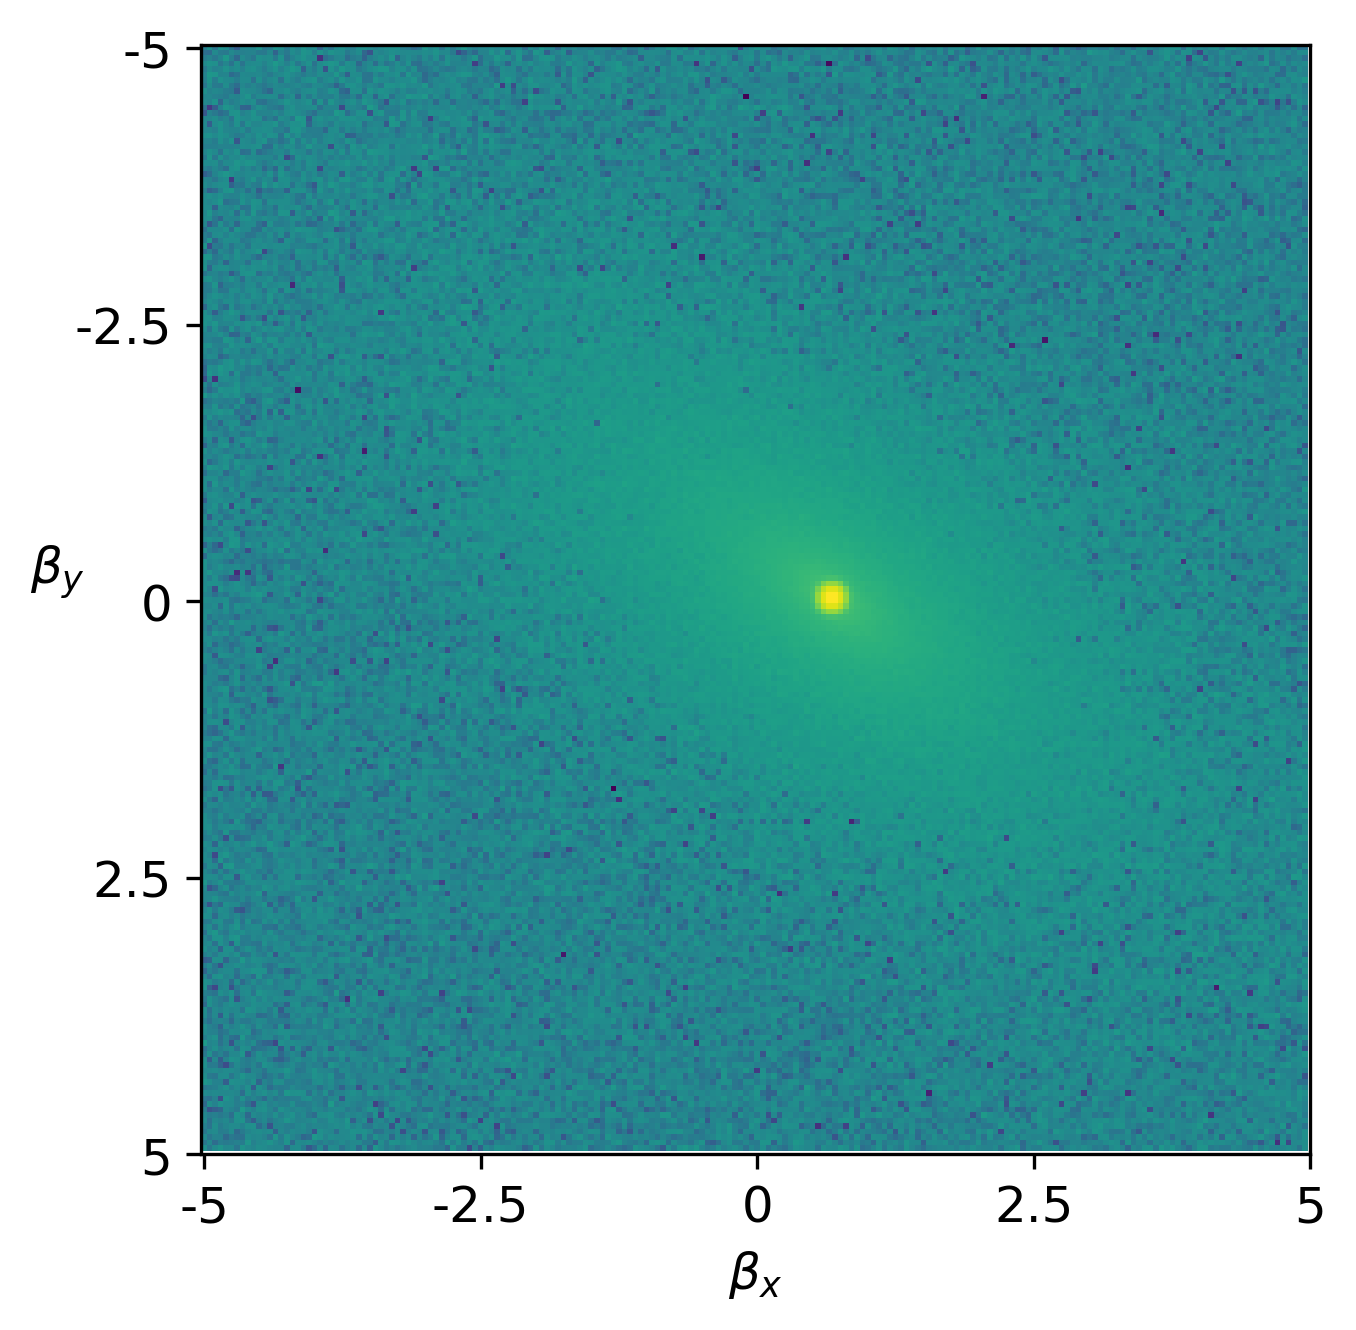

In [18]:
# Creamos las imágenes simuladas lensadas y sin lensar
kwargs_numerics = {"supersampling_factor": 1,
"supersampling_convolution": False}


# Usamos clase Point_Source para el cuasar
# Posición del cuásar en el plano de la fuente
kwargs_ps = [{"ra_image": [ra_source],
"dec_image": [dec_source],
"point_amp": [100000]}]
point_source_list2 = ["UNLENSED"]
point_source_class2 =PointSource(point_source_type_list=point_source_list2,
fixed_magnification_list=[False])

# Generamos imagen sin lensar
imageModel2 = ImageModel(data_class, psf_class,lens_light_model_class=source_model_class,
                         point_source_class=point_source_class2,
                         kwargs_numerics=kwargs_numerics)
image2 = imageModel2.image(kwargs_lens_light=kwargs_source, kwargs_ps=kwargs_ps)
poisson = image_util.add_poisson(image2, exp_time=exp_time) # ruido poisson
bkg = image_util.add_background(image2, sigma_bkd=background_rms) # ruido de fondo
image2 = image2 + bkg + poisson # imagen sin lensar

# Graficamos en escala logarítmica
data=np.log10(np.abs(image2))
img=plt.imshow(data,cmap='viridis',vmin=data.min(),vmax=data.max())
plt.xlabel(r'$\beta_x$')
plt.ylabel(r'$\beta_y$ ',rotation=0)
plt.xticks([0,50,100,150,200],[-5,-2.5,0,2.5,5])
plt.yticks([0,50,100,150,200],[-5,-2.5,0,2.5,5])
plt.show()


### 1.6 Simulamos imagen lensada
Introduciendo la lente en la clase `ImageModel` y las soluciones de la ecuación de la lente conseguimos la imagen de la galaxia y el cuásar lensado.

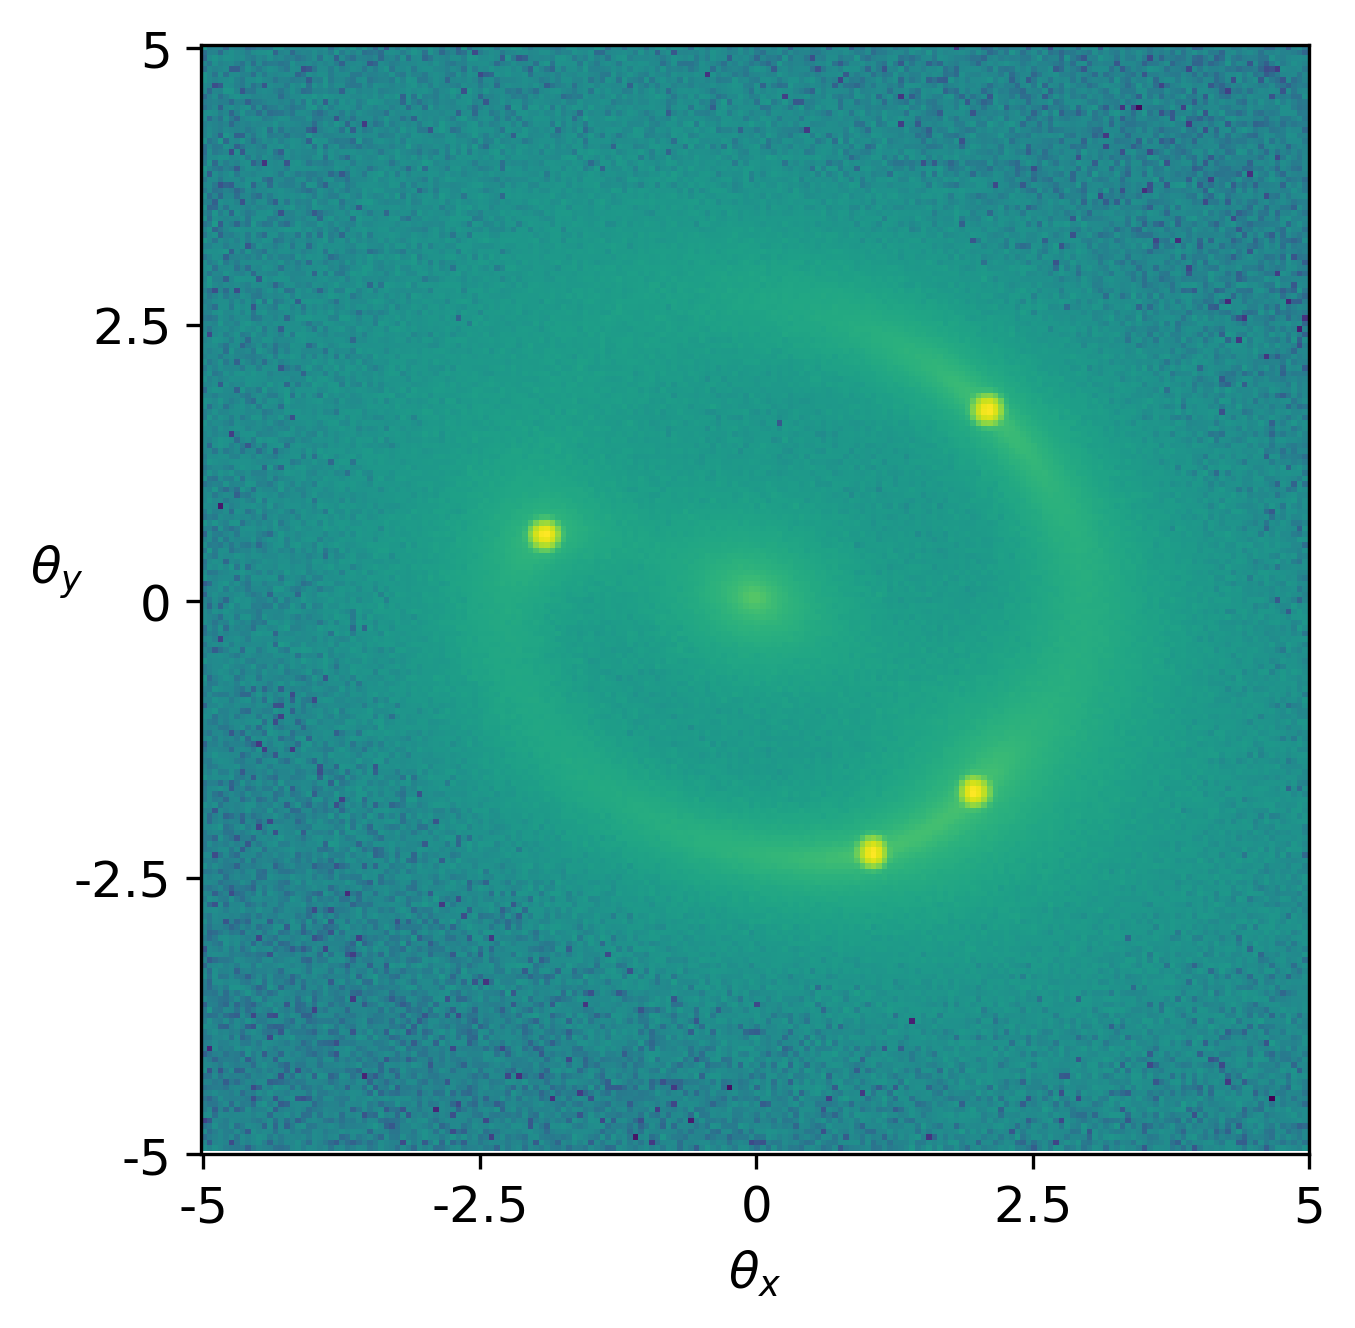

In [19]:
# Usamos clase Point_Source para el cuasar
# Posición de las imágenes del cuasar
kwargs_ps = [{"ra_image": x_image,
"dec_image": y_image,
"point_amp": 100000}] # Imponemos gran luminosidad del cuásar
point_source_list = ["LENSED_POSITION"]
point_source_class =PointSource(point_source_type_list=point_source_list,
fixed_magnification_list=[False])

# Incluimos los efectos de psf, de ruido etc.
imageModel = ImageModel(data_class, psf_class, lens_model_class,source_model_class,lens_light_model_class,point_source_class,
                        kwargs_numerics=kwargs_numerics)

# La imagen lensada
image_sim = imageModel.image(kwargs_lens, kwargs_source,kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

# Graficamos
data=np.log10(np.abs(image_sim))
img=plt.imshow(data,cmap='viridis',vmin=data.min(),vmax=data.max())
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$\theta_y$ ',rotation=0)
plt.xticks([0,50,100,150,200],[-5,-2.5,0,2.5,5])
plt.yticks([0,50,100,150,200],[5,2.5,0,-2.5,-5])
plt.show()


## 2. Algoritmo de reconstrucción
En este apartado se usa la imagen lensada simulada para recuperar los parámetros de la lente empleados. Como única restricción escogemos las imágenes del cuásar lensado.



>[!WARNING]
>(Este algoritmo es ineficiente, hay algunos más eficientes, por tanto es mejor ejecutarlo en Python directamente mediante el archivo [Reconstrucción.py](./Reconstruccion.py)).